<a href="https://colab.research.google.com/github/GauraoM/PyTorch/blob/main/Training_Generative_Adverserial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='sample_data/', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])) # Subtract 0.5 and divide by 0.5

In [98]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

##### As, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [99]:
# Denormalize the image
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1) # Gives values between range 0-1

Label: 5


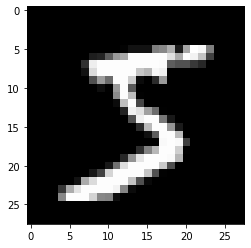

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img) # Denormalize the image
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

##### Create dataloader to load the images in batches

In [101]:
from torch.utils.data.dataloader import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([7, 6, 0, 7, 3, 4, 0, 7, 8, 2, 3, 7, 9, 5, 3, 0, 7, 4, 0, 3, 6, 0, 6, 2,
        3, 4, 6, 8, 1, 1, 1, 4, 7, 5, 8, 0, 1, 5, 7, 3, 6, 3, 6, 4, 0, 7, 4, 6,
        2, 0, 1, 5, 9, 6, 1, 1, 4, 6, 2, 9, 2, 4, 9, 1, 2, 2, 7, 7, 4, 1, 8, 5,
        2, 7, 7, 3, 9, 3, 7, 4, 8, 1, 8, 8, 5, 7, 0, 0, 3, 9, 1, 8, 9, 0, 2, 6,
        6, 5, 9, 2])


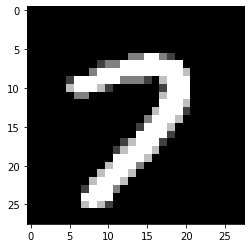

In [102]:
for img_batch, label_batch in data_loader: # 100,1,28,28
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [103]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [104]:
device

device(type='cuda')

#### Discriminator Network
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784

In [105]:
image_size = 784
hidden_size = 64

In [106]:
import torch.nn as nn
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [107]:
D.to(device) # Move discriminator to device

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)

#### Generator Network
The input to the generator is typically a vector or a matrix which is used as a seed for generating an image.we will use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 pixel image.

In [108]:
latent_size = 64

In [109]:
from torch.nn.modules.activation import ReLU
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()

)

In [110]:
# Generate an output vector using the generator and view it as an image by transforming and denormalizing the output.
# Generate 2 images with the help of generator
y = G(torch.randn(2,latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach()) #Didn' track any gradient, just return new Tensor

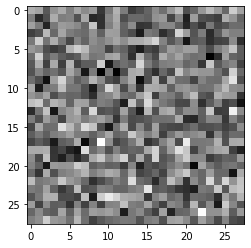

In [111]:
plt.imshow(gen_imgs[0], cmap='gray');

In [112]:
G.to(device) ## Move discriminator to device

Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=784, bias=True)
  (5): Tanh()
)

#### Discriminator Training
Since the discriminator is a binary classification model, we can use binary cross entropy loss function to differentiated between real and fake images.

In [113]:
criterion = nn.BCELoss() # Binary cross entropy
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

##### Helper function to reset gradient and train the discriminator

In [114]:
# Reset the gradient
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

# train_discriminator
def train_discriminator(images):

  # Create the labels for real and fake images which are later used as input for the BCE loss
  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  # Loss for real images
  outputs = D(images)
  d_loss_real = criterion(outputs,real_labels)
  real_score = outputs

  # Loss for fake images
  z = torch.randn(batch_size, latent_size).to(device) # Generate 100 latent vectors and move them to device
  fake_images = G(z) # 100 fake images
  outputs = D(fake_images) # pass tehm to descriminator
  d_loss_fake = criterion(outputs,fake_labels)
  fake_score = outputs

  # Combine losses
  d_loss = d_loss_real + d_loss_fake

  # Reset gradient
  reset_grad()

  # Compute Gradient
  d_loss.backward()

  # Adjust the parameters using backpropogation
  d_optimizer.step()

  return d_loss, real_score, fake_score

#### Generator Training
We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

In [115]:
def train_generator():
  # generate fake images and calculate loss
  z = torch.randn(batch_size, latent_size).to(device) # Take a random batch of latent vectors and move them to device
  fake_images = G(z)                              # give vector to generator
  labels = torch.ones(batch_size,1).to(device) # create labels of one of batch size
  g_loss = criterion(D(fake_images), labels) #get loss

  # Backpropogation and optimize
  reset_grad() # Reset gradient
  g_loss.backward() # Compute Gradient
  g_optimizer.step() # Adjust the parameters using backpropogation
  return g_loss, fake_images

#### Training model
Create a directory where we can save intermediate outputs from generator to save the generators output , to visually inspect the progress of the model

In [116]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

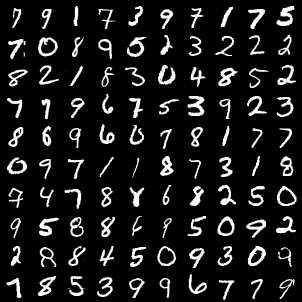

In [117]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
  images = images.reshape(images.size(0), 1,28, 28) # reshape the image
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10) # Denormalize image and save it to sample_dir
  break
   
Image(os.path.join(sample_dir, 'real_images.png'))

##### Helper function to save a batch of generated images to disk at the end of every epoch.To see how they are evolved over time

Saving fake_images-0000.png


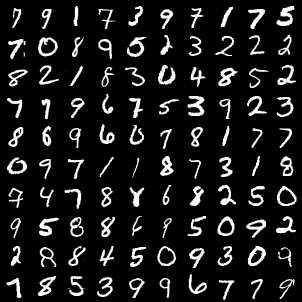

In [118]:
sample_vector = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vector) #generate fake images
  fake_images = images.reshape(images.size(0), 1,28, 28) # reshape it 
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index) # save the image with bacth index
  print('Saving',fake_fname)
  save_image(denorm(images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

##### In each epoch, we nedd to train the discriminator first, and then the generator.

In [124]:
%%time

num_epochs = 40
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Iterate over epochs
for epoch in range(num_epochs):
    # Get batch number and image
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors(flattens out the image)
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses(at every 200th images)
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item()) # average probability discriminator returns for real images
            fake_scores.append(fake_score.mean().item()) # average probability discriminator returns for fake images
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/40], Step [200/600], d_loss: 0.2080, g_loss: 5.8895, D(x): 0.95, D(G(z)): 0.09
Epoch [0/40], Step [400/600], d_loss: 0.2407, g_loss: 6.2577, D(x): 0.96, D(G(z)): 0.06
Epoch [0/40], Step [600/600], d_loss: 0.3204, g_loss: 6.7436, D(x): 0.90, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/40], Step [200/600], d_loss: 0.0539, g_loss: 6.1612, D(x): 0.98, D(G(z)): 0.02
Epoch [1/40], Step [400/600], d_loss: 0.1333, g_loss: 5.5184, D(x): 0.94, D(G(z)): 0.03
Epoch [1/40], Step [600/600], d_loss: 0.1675, g_loss: 4.6698, D(x): 0.95, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/40], Step [200/600], d_loss: 0.0997, g_loss: 5.0328, D(x): 0.98, D(G(z)): 0.06
Epoch [2/40], Step [400/600], d_loss: 0.0950, g_loss: 5.5118, D(x): 0.96, D(G(z)): 0.03
Epoch [2/40], Step [600/600], d_loss: 0.1781, g_loss: 5.8134, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/40], Step [200/600], d_loss: 0.2927, g_loss: 6.3533, D(x): 0.88, D(G(z)): 0.01
Epoch [3/40], Step [400/600], d_loss

In [125]:
import cv2
import os
from IPython.display import FileLink


vid_fname = 'gans_training.avi'

# Find the Fake images and join them
files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'fake_images' in f]

files.sort() # sort the files

# Create a video
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

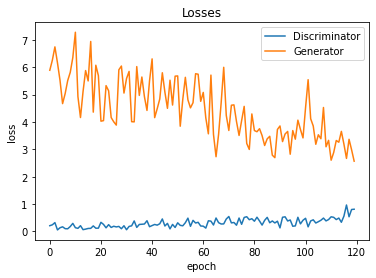

In [126]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

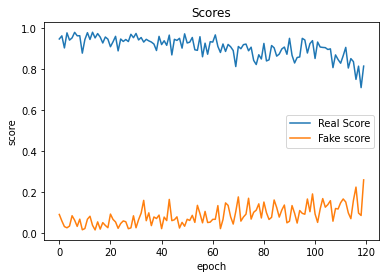

In [127]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');